# Analysis of the ABIDE dataset

### Imports

In [2]:
import warnings
import os
from os.path import join
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import quantile_transform
from sklearn.metrics import roc_curve, RocCurveDisplay
from nilearn.datasets.utils import _uncompress_file, _fetch_file
from nilearn.connectome import ConnectivityMeasure

from neurocombat_sklearn import CombatModel

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.formula.api import ols as ols_f

from mlconfound.stats import full_confound_test, partial_confound_test
from mlconfound.plot import plot_graph
from mlconfound.stats import _r2_cat_cont, _r2_cont_cont, _r2_cat_cat

## Load data

In [3]:
data_dir = 'data/ABIDE'

url = 'https://osf.io/hc4md/download'

# Download the zip file, first
dl_file = _fetch_file(url, data_dir=data_dir)

# Second, uncompress the downloaded zip file
_uncompress_file(dl_file, verbose=2)


Resuming failed, try to download the whole file.


Downloaded 1794277376 of 1811491701 bytes (99.0%,    0.5s remaining) ...done. (59 seconds, 0 min)
Extracting data from data/ABIDE/download..... done.


In [4]:
def _get_paths(phenotypic, atlas, timeseries_dir):
    timeseries = []
    IDs_subject = []
    diagnosis = []
    subject_ids = phenotypic['SUB_ID']
    mean_fd = []
    num_fd = []
    perc_fd = []
    site = []
    for index, subject_id in enumerate(subject_ids):
        this_pheno = phenotypic[phenotypic['SUB_ID'] == subject_id]
        this_timeseries = join(timeseries_dir, atlas,
                               str(subject_id) + '_timeseries.txt')
        if os.path.exists(this_timeseries):
            timeseries.append(np.loadtxt(this_timeseries))
            IDs_subject.append(subject_id)
            diagnosis.append(this_pheno['DX_GROUP'].values[0])
            mean_fd.append(this_pheno['func_mean_fd'].values[0])
            num_fd.append(this_pheno['func_num_fd'].values[0])
            perc_fd.append(this_pheno['func_perc_fd'].values[0])
            site.append(this_pheno['SITE_ID'].values[0])
    return timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site

Download the phenotypic summary information file form the preprocessed connectomes project.
- First read:
  http://preprocessed-connectomes-project.org/abide/download.html
- Then download:
  https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv
- Copy the csv file into the data_in/ABIDE directory

In [5]:
phenotypic = pd.read_csv('data/ABIDE/Phenotypic_V1_0b_preprocessed1.csv').iloc[:,2:]
timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site = _get_paths(phenotypic, "BASC/regions", 'data/ABIDE/')
sites, site_int = np.unique(site, return_inverse=True)
phenotypic.columns.values

array(['SUB_ID', 'X', 'subject', 'SITE_ID', 'FILE_ID', 'DX_GROUP',
       'DSM_IV_TR', 'AGE_AT_SCAN', 'SEX', 'HANDEDNESS_CATEGORY',
       'HANDEDNESS_SCORES', 'FIQ', 'VIQ', 'PIQ', 'FIQ_TEST_TYPE',
       'VIQ_TEST_TYPE', 'PIQ_TEST_TYPE', 'ADI_R_SOCIAL_TOTAL_A',
       'ADI_R_VERBAL_TOTAL_BV', 'ADI_RRB_TOTAL_C', 'ADI_R_ONSET_TOTAL_D',
       'ADI_R_RSRCH_RELIABLE', 'ADOS_MODULE', 'ADOS_TOTAL', 'ADOS_COMM',
       'ADOS_SOCIAL', 'ADOS_STEREO_BEHAV', 'ADOS_RSRCH_RELIABLE',
       'ADOS_GOTHAM_SOCAFFECT', 'ADOS_GOTHAM_RRB', 'ADOS_GOTHAM_TOTAL',
       'ADOS_GOTHAM_SEVERITY', 'SRS_VERSION', 'SRS_RAW_TOTAL',
       'SRS_AWARENESS', 'SRS_COGNITION', 'SRS_COMMUNICATION',
       'SRS_MOTIVATION', 'SRS_MANNERISMS', 'SCQ_TOTAL', 'AQ_TOTAL',
       'COMORBIDITY', 'CURRENT_MED_STATUS', 'MEDICATION_NAME',
       'OFF_STIMULANTS_AT_SCAN', 'VINELAND_RECEPTIVE_V_SCALED',
       'VINELAND_EXPRESSIVE_V_SCALED', 'VINELAND_WRITTEN_V_SCALED',
       'VINELAND_COMMUNICATION_STANDARD', 'VINELAND_PERSONAL_V_S

(41.170464362909215, 5.142594423450439)

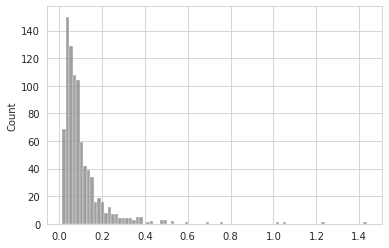

In [7]:
sns.histplot(mean_fd, color='gray')
plt.savefig('../fig/raw/emp_abide_motion_hist.pdf')
kurtosis(mean_fd), skew(mean_fd)

(0.492398885189945, 0.6060249878053774)

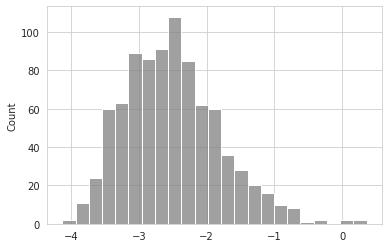

In [8]:
sns.histplot(np.log(mean_fd), color='gray')
kurtosis(np.log(mean_fd)), skew(np.log(mean_fd))

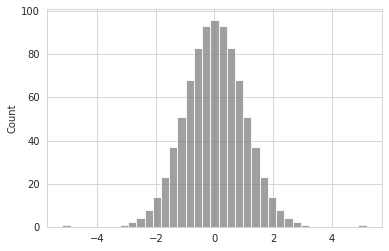

In [9]:
rng = np.random.default_rng(42)
mean_fd_trf = quantile_transform(np.array([mean_fd]).T, output_distribution='normal',
                                 n_quantiles=len(mean_fd)).flatten()

sns.histplot(mean_fd_trf, color='gray')
plt.savefig('../fig/raw/emp_abide_motion_quanttrf_hist.pdf')

kurtosis(mean_fd_trf), skew(mean_fd_trf)
mean_fd = mean_fd_trf


## Binning motion data (to be used later)

In [10]:
# binning mean_fd
bins = 10 # approximately 80 subject per motion group

limits = np.quantile(mean_fd, np.arange(0, 1, 1/bins))
mean_fd_binned = np.digitize(mean_fd, limits)

## Calculate connectivity

In [11]:
connections = ConnectivityMeasure(kind='tangent', vectorize=True, discard_diagonal=True)
conn_coefs = connections.fit_transform(timeseries)

In [12]:
_, y = np.unique(diagnosis, return_inverse=True)
X = conn_coefs

# Machine learning (raw)

In [13]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    ('model', LogisticRegression())])

p_grid = {'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
    predicted_prob[test] = clf.predict_proba(X[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.7100334219236659 0.690880169671262
cv: 1 {'model__C': 0.1} 0.7120691684716075 0.6458112407211029
cv: 2 {'model__C': 0.1} 0.7018831113343309 0.6851063829787234
cv: 3 {'model__C': 0.1} 0.683804187462724 0.8202127659574467
cv: 4 {'model__C': 1} 0.6986948621094962 0.7351063829787234
cv: 5 {'model__C': 0.1} 0.7201791512767122 0.6872340425531914
cv: 6 {'model__C': 0.1} 0.6974297468199907 0.7592391304347826
cv: 7 {'model__C': 0.1} 0.7031858949541876 0.7597826086956522
cv: 8 {'model__C': 0.1} 0.7127732261878603 0.7440217391304348
cv: 9 {'model__C': 0.1} 0.7333955035174546 0.6059782608695652


** Mean score in the inner crossvaludation (inner_cv):	0.7073448274058031
** Mean Nested Crossvalidation Score (outer_cv):	0.7133372723990885


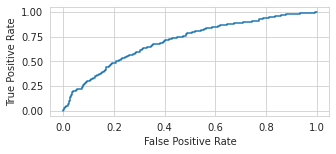

In [14]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../fig/raw/emp_abide_raw_rocplot.pdf')


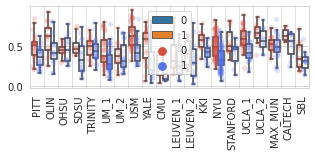

In [15]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[-1], sns.color_palette("coolwarm", 10)[0]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
plt.savefig('../fig/raw/emp_abide_site_raw_striplot.pdf')

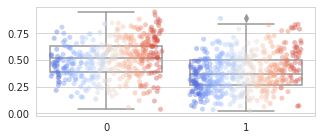

In [16]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.legend([],[], frameon=False)
plt.savefig('../fig/raw/emp_abide_motion_raw_stripplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 630.74it/s]


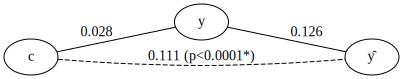

In [17]:
plot_graph(partial_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                     random_state=42),
          outfile_base='../fig/raw/emp_abide_motion_raw_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 532.68it/s]


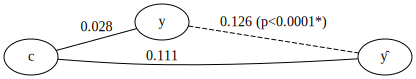

In [18]:
plot_graph(full_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                 random_state=42),
          outfile_base='../fig/raw/emp_abide_motion_raw_full')

In [19]:
nulldist = []
unpermuted = _r2_cont_cont(predicted_prob, mean_fd)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cont_cont(yperm, mean_fd))
(nulldist >= unpermuted).sum()/len(nulldist)


0.11075648305937133


0.0

In [20]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.12636970891102528


0.0

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 487.26it/s]


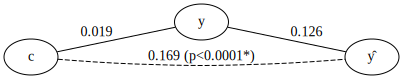

In [21]:
plot_graph(partial_confound_test(y, predicted_prob, site_int,
                                     cat_y=True, cat_yhat=False, cat_c=True,
                                     random_state=42),
          outfile_base='../fig/raw/emp_abide_site_raw_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 519.46it/s]


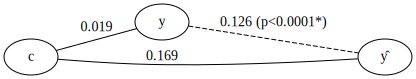

In [22]:
plot_graph(full_confound_test(y, predicted_prob, site_int,
                                 cat_y=True, cat_yhat=False, cat_c=True,
                                 random_state=42),
          outfile_base='../fig/raw/emp_abide_site_raw_full')

In [23]:
nulldist = []
unpermuted = _r2_cat_cont(site_int, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(site_int, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.16862432442215103


0.0

In [24]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.12636970891102528


0.0

# Regress out motion from the feature

In [25]:
# regress-out motion from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    OLS_model = OLS(X[:,i], sm.add_constant(mean_fd)).fit()  # training the model
    X_adj[:, i] = OLS_model.resid

In [26]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X_adj[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
    predicted_prob[test] = clf.predict_proba(X_adj[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.575732134573598 0.679745493107105
cv: 1 {'model__C': 0.1} 0.5862695012085257 0.5922587486744432
cv: 2 {'model__C': 0.1} 0.5971689023518292 0.5494680851063829
cv: 3 {'model__C': 0.1} 0.5795941847771116 0.6558510638297872
cv: 4 {'model__C': 0.1} 0.5901033873594849 0.6446808510638298
cv: 5 {'model__C': 0.1} 0.6414546515156271 0.45
cv: 6 {'model__C': 0.1} 0.5846736980883322 0.6701086956521739
cv: 7 {'model__C': 0.1} 0.6039699542748325 0.5945652173913043
cv: 8 {'model__C': 0.1} 0.6184660706002169 0.5201086956521739
cv: 9 {'model__C': 0.1} 0.6278473595546766 0.5266304347826086


** Mean score in the inner crossvaludation (inner_cv):	0.6005279844304235
** Mean Nested Crossvalidation Score (outer_cv):	0.5883417285259809


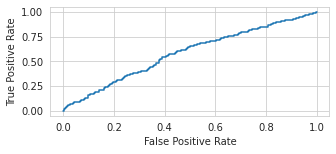

In [27]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../fig/raw/emp_abide_motion_reg_rocplot.pdf')
    

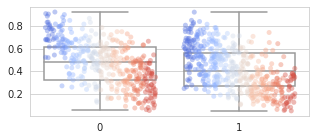

In [28]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.legend([],[], frameon=False)
plt.savefig('../fig/raw/emp_abide_motion_reg_stripplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 810.67it/s]


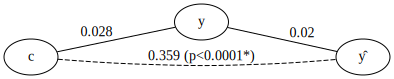

In [29]:
plot_graph(partial_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                     random_state=42),
          outfile_base='../fig/raw/emp_abide_motion_reg_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 500.05it/s]


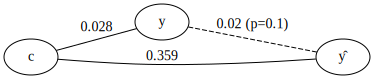

In [30]:
plot_graph(full_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                 random_state=42),
          outfile_base='../fig/raw/emp_abide_motion_reg_full')

In [31]:
nulldist = []
unpermuted = _r2_cont_cont(predicted_prob, mean_fd)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cont_cont(yperm, mean_fd))
(nulldist >= unpermuted).sum()/len(nulldist)

0.35940432840757963


0.0

In [32]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.01983830774607609


0.0

# Regress out site

In [33]:
# regress-out acquisition from connectivity
X_adj = np.zeros_like(X)
for i in range(X.shape[1]):
    tmp = pd.DataFrame({
        'x': site_int,
        'y': X[:,i]
    })
    OLS_model = ols_f("y ~ C(x)", tmp).fit()  # training the model
    X_adj[:, i] = OLS_model.resid.values

In [34]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X_adj))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X_adj))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):

    clf.fit(X_adj[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_adj[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_adj[test])
    predicted_prob[test] = clf.predict_proba(X_adj[test])[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_adj[test], y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.7512998189827458 0.6956521739130435
cv: 1 {'model__C': 0.1} 0.7602222431490724 0.653764581124072
cv: 2 {'model__C': 0.1} 0.7382248101760297 0.7797872340425532
cv: 3 {'model__C': 10} 0.7533220502732698 0.8308510638297872
cv: 4 {'model__C': 0.1} 0.7311433384604116 0.7856382978723404
cv: 5 {'model__C': 0.1} 0.7137365152609055 0.8664893617021276
cv: 6 {'model__C': 0.1} 0.7290465552660674 0.7478260869565218
cv: 7 {'model__C': 0.1} 0.7255997722461138 0.8108695652173913
cv: 8 {'model__C': 0.1} 0.737317238841629 0.771195652173913
cv: 9 {'model__C': 0.1} 0.7495317617268836 0.6157608695652174


** Mean score in the inner crossvaludation (inner_cv):	0.7389444104383128
** Mean Nested Crossvalidation Score (outer_cv):	0.7557834886396967


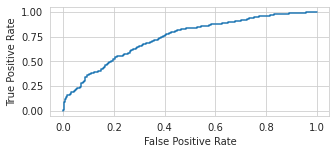

In [35]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../fig/raw/emp_abide_site_reg_rocplot.pdf')
    

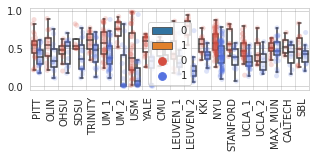

In [36]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[-1], sns.color_palette("coolwarm", 10)[0]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
plt.savefig('../fig/raw/emp_abide_site_reg_striplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 452.98it/s]


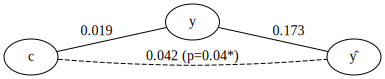

In [37]:
plot_graph(partial_confound_test(y, predicted_prob, site_int,
                                     cat_y=True, cat_yhat=False, cat_c=True,
                                     random_state=42),
          outfile_base='../fig/raw/emp_abide_site_reg_partial')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 479.15it/s]


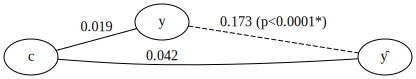

In [38]:
plot_graph(full_confound_test(y, predicted_prob, site_int,
                                 cat_y=True, cat_yhat=False, cat_c=True,
                                 random_state=42),
          outfile_base='../fig/raw/emp_abide_site_reg_full')

In [39]:
nulldist = []
unpermuted = _r2_cat_cont(site_int, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(site_int, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.04243881759371848


0.004

In [40]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.1730211479165208


0.0

# Combat on binned motion data

In [41]:
outer_cv = StratifiedKFold(10)
inner_cv = StratifiedKFold(10) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):
    
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([mean_fd_binned[train]]).transpose()
                                  )


    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([mean_fd_binned[test]]).transpose())

                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
    predicted_prob[test] = clf.predict_proba(X_test_combat)[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.6645641721861234 0.7067868504772005
cv: 1 {'model__C': 0.1} 0.6695913247742515 0.6813361611876988
cv: 2 {'model__C': 0.1} 0.6594625984869887 0.6930851063829787
cv: 3 {'model__C': 0.1} 0.6608973956534931 0.8074468085106383
cv: 4 {'model__C': 0.1} 0.6629321394565297 0.7287234042553191
cv: 5 {'model__C': 0.1} 0.7064102865932134 0.6425531914893616
cv: 6 {'model__C': 0.1} 0.6678523035230352 0.7581521739130436
cv: 7 {'model__C': 0.1} 0.6746544453861528 0.7472826086956521
cv: 8 {'model__C': 0.1} 0.6961607077460735 0.6646739130434782
cv: 9 {'model__C': 0.1} 0.6957503670918306 0.5815217391304348


** Mean score in the inner crossvaludation (inner_cv):	0.6758275740897691
** Mean Nested Crossvalidation Score (outer_cv):	0.7011561957085806


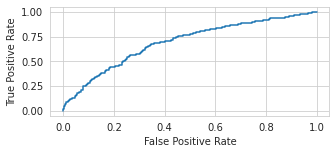

In [42]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../fig/raw/emp_abide_motion_comb_rocplot.pdf')  
    

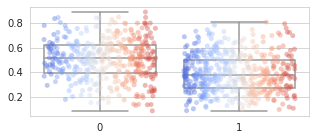

In [43]:
plt.figure(figsize=(5,2))
sns.stripplot(x=y, y=predicted_prob, hue=mean_fd_binned,
              palette="coolwarm", alpha=0.4, jitter=0.4, dodge=True)
plt.legend([],[], frameon=False)
sns.boxplot(x=y, y=predicted_prob, color=(1,1,1,1))
plt.savefig('../fig/raw/emp_abide_motion_comb_stripplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 840.66it/s]


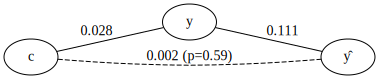

In [44]:
plot_graph(partial_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                     random_state=42),
          outfile_base='../fig/raw/emp_abide_motion_comb_partial')

Permuting: 100%|██████████| 1000/1000 [00:01<00:00, 521.98it/s]


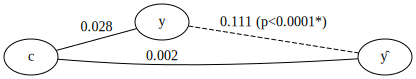

In [45]:
plot_graph(full_confound_test(y, predicted_prob, mean_fd, cat_y=True, cat_yhat=False,
                                 random_state=42),
          outfile_base='../fig/raw/emp_abide_motion_comb_full')

In [46]:
nulldist = []
unpermuted = _r2_cont_cont(predicted_prob, mean_fd)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cont_cont(yperm, mean_fd))
(nulldist >= unpermuted).sum()/len(nulldist)

0.001963925089027347


0.209

In [47]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.11138396090241687


0.0

# Combat on site

In [48]:
outer_cv = StratifiedKFold(10, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(10, shuffle=True, random_state=42) 
model = Pipeline([
    ('varthr', VarianceThreshold(0)),   # omit zero variance columns (diagonal)
    #('fsel', SelectKBest(f_regression)),
    ('model', LogisticRegression())])

p_grid = {#'fsel__k': [500, 1000, 2000],
          'model__C': [0.1, 1, 10]}

clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=StratifiedKFold(10),
                   scoring="roc_auc", return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
predicted_prob = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y):
    
    comb = CombatModel()
    X_train_combat = comb.fit_transform(X[:,np.sum(X,0)!=0][train],
                                   np.array([site_int[train]]).transpose()
                                  )


    clf.fit(X_train_combat, y[train])
    
    X_test_combat = comb.transform(X[:,np.sum(X,0)!=0][test],
                                   np.array([site_int[test]]).transpose())

                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X_test_combat, y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X_test_combat)
    predicted_prob[test] = clf.predict_proba(X_test_combat)[:,0]
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X_test_combat, y[test])
    i = i+1

model	inner_cv mean score	outer vc score
cv: 0 {'model__C': 0.1} 0.7501508477118233 0.7290562036055144
cv: 1 {'model__C': 0.1} 0.7358902020487387 0.7576882290562036
cv: 2 {'model__C': 0.1} 0.7447366355902941 0.7026595744680851
cv: 3 {'model__C': 0.1} 0.7346093044263775 0.7696808510638298
cv: 4 {'model__C': 0.1} 0.7258576084795597 0.7973404255319149
cv: 5 {'model__C': 0.1} 0.751687881261052 0.6675531914893617
cv: 6 {'model__C': 1} 0.7394399626106943 0.7913043478260869
cv: 7 {'model__C': 1} 0.7423432578920385 0.7369565217391304
cv: 8 {'model__C': 0.1} 0.7492881383125284 0.7266304347826087
cv: 9 {'model__C': 0.1} 0.7345418589321029 0.7728260869565218


** Mean score in the inner crossvaludation (inner_cv):	0.740854569726521
** Mean Nested Crossvalidation Score (outer_cv):	0.7451695866519257


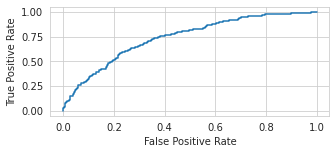

In [49]:
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))

fpr, tpr, _ = roc_curve(y, predicted_prob, pos_label=0)
fig, ax = plt.subplots(figsize=(5,2))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax) 
plt.savefig('../fig/raw/emp_abide_site_comb_rocplot.pdf')  

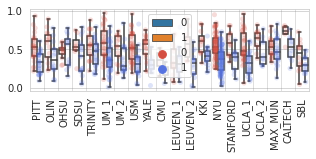

In [50]:
plt.figure(figsize=(5,1.5))

pal=[sns.color_palette("coolwarm", 10)[-1], sns.color_palette("coolwarm", 10)[0]]
sns.stripplot(x=site, y=predicted_prob, hue=y, palette=pal, alpha=0.2, jitter=0.2, dodge=True)
ax=sns.boxplot(x=site, y=predicted_prob, hue=y, showfliers = False)
for box in ax.artists:
    box.set_facecolor((1,1,1,0))
plt.xticks(rotation=90)
for i in range(len(np.unique(site))):
    plt.axvline(i+0.5, color="gray", alpha=0.5, linewidth=0.5)
plt.savefig('../fig/raw/emp_abide_site_comb_striplot.pdf')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 492.06it/s]


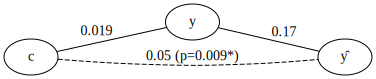

In [51]:
plot_graph(partial_confound_test(y, predicted_prob, site_int,
                                     cat_y=True, cat_yhat=False, cat_c=True,
                                     random_state=42),
          outfile_base='../fig/raw/emp_abide_site_comb_partial')

Permuting: 100%|██████████| 1000/1000 [00:02<00:00, 486.45it/s]


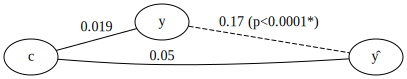

In [52]:
plot_graph(full_confound_test(y, predicted_prob, site_int,
                                 cat_y=True, cat_yhat=False, cat_c=True,
                                 random_state=42),
          outfile_base='../fig/raw/emp_abide_site_comb_full')

In [53]:
nulldist = []
unpermuted = _r2_cat_cont(site_int, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(site_int, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)

0.04978966375151461


0.001

In [54]:
nulldist = []
unpermuted = _r2_cat_cont(y, predicted_prob)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(predicted_prob)
    nulldist.append(_r2_cat_cont(y, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)


0.17032841128735843


0.0

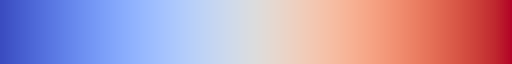

In [55]:

sns.color_palette("coolwarm", as_cmap=True)

In [56]:
np.max(mean_fd)

5.19933758270342

In [57]:
nulldist = []
unpermuted = _r2_cat_cont(y, mean_fd)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(y)
    nulldist.append(_r2_cat_cont(yperm, mean_fd))
(nulldist >= unpermuted).sum()/len(nulldist)



0.02798282700643162


0.0

In [58]:
nulldist = []
unpermuted = _r2_cat_cat(site_int, y)

print(unpermuted)

for i in range(1000):
    yperm = np.random.permutation(y)
    nulldist.append(_r2_cat_cat(site_int, yperm))
(nulldist >= unpermuted).sum()/len(nulldist)




0.019007371520746053


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


0.253